###Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import functools
#np.random.seed(101)

CMA-ES Implementation

Covariance matrix adaptation evolution strategy (CMA-ES) is a black-box, stochastic, derivative-free methods for numerical optimization for non-linear or non-convex continuous optimization problems.

In [2]:
def cmaes(fn, dim, num_iter=10):
  """
  Implementation of CMA-ES.
  Args:
    fn: A function that takes as input a vector and outputs a scalar value.
    dim: (int) The dimension of the vector that fn expects as input.
    num_iter: (int) Number of iterations to run CMA-ES.

  Returns:
    mu_vec: An array of size [num_iter, dim] storing the value of mu at each
      iteration.
    best_sample_vec: A list of length [num_iter] storing the function value
      for the best sample from each iteration of CMA-ES.
    mean_sample_vec: A list of length [num_iter] storing the average function
      value across samples from each iteration of CMA-ES.
  """
  # Hyperparameters
  sigma = 10
  population_size = 100
  p_keep = 0.10  # Fraction of population to keep
  noise = 0.25  # Noise added to covariance to prevent it from going to 0.

  # Initialize the mean and covariance
  mu = np.zeros(dim)
  cov = sigma**2 * np.eye(dim)

  mu_vec = []
  best_sample_vec = []
  mean_sample_vec = []
  num_elite = int(p_keep * population_size)
  for t in range(num_iter):
    # append mu value for each iteration
    mu_vec.append(mu)
    # generate random samples from multivariate normal distribution
    x=np.random.multivariate_normal(mu,cov,population_size)
    # compute the function values
    fx=list(map(fn, x))
    # keep the top parameters based on function values(top 10 in this implementation)
    elite_idx=(np.argsort(fx))[::-1][:num_elite]
    # update mu and cov with seleted elites for the next iteration
    mu = np.mean(x[elite_idx],axis=0)
    cov = np.cov(x[elite_idx],rowvar=False)+noise*np.identity(dim)
    # keep the best function value and mean function value across samples
    best_sample_vec.append(max(fx))
    mean_sample_vec.append(np.average(fx))
  return mu_vec, best_sample_vec, mean_sample_vec

**Test Performance of CMA-ES**

The following function:
$$f(x) = -\|x - x^*\|_2^2 \quad \text{where} \quad x^* = [42, 77].$$
is optimized when $x = x^*$. Test the performance of CMA-ES on this function to confirm it can achieve correct solution.

In [3]:
def test_fn(x):
  goal = np.array([42, 77])
  return -np.sum((x - goal)**2)

mu_vec, best_sample_vec, mean_sample_vec = cmaes(test_fn, dim=2, num_iter=100)
print(mu_vec[-1])

[41.99632373 76.97174071]


**Visualize CMA-ES**

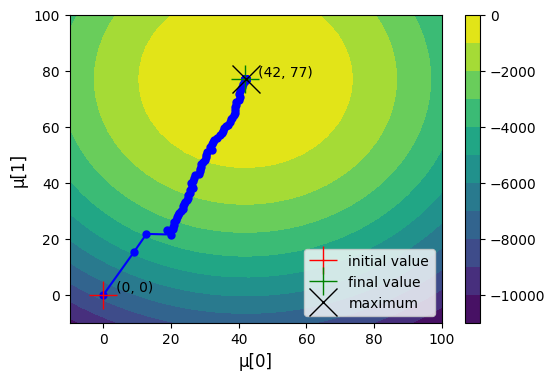

In [4]:
x = np.stack(np.meshgrid(np.linspace(-10, 100, 30), np.linspace(-10, 100, 30)), axis=-1)
fn_value = [test_fn(xx) for xx in x.reshape((-1, 2))]
fn_value = np.array(fn_value).reshape((30, 30))
plt.figure(figsize=(6, 4))
plt.contourf(x[:, :, 0], x[:, :, 1], fn_value, levels=10)
plt.colorbar()
mu_vec = np.array(mu_vec)
plt.plot(mu_vec[:, 0], mu_vec[:, 1], 'b-o',markersize=5)
plt.plot([mu_vec[0, 0]], [mu_vec[0, 1]], 'r+', ms=20, label='initial value')
plt.plot([mu_vec[-1, 0]], [mu_vec[-1, 1]], 'g+', ms=20, label='final value')
plt.plot([42], [77], 'kx', ms=20, label='maximum')
mu_0= [mu_vec[0, 0], mu_vec[-1, 0]]
mu_1=[mu_vec[0, 1],mu_vec[-1, 1]]
for x, y in zip(mu_0,mu_1):
    plt.text(x, y, '   ({}, {})'.format(round(x),round(y)),fontsize=10, ha='left',va='bottom')
plt.xlabel('\u03BC[0]',fontsize=12)
plt.ylabel('\u03BC[1]',fontsize=12)
plt.legend(loc='lower right')
plt.show()

**Maximize the expected reward of a RL agent**

The policy takes action LEFT with probability:
$$\pi(a = \text{LEFT} \mid s) = s \cdot w + b,$$
where $w \in \mathbb{R}^4$ and $b \in \mathbb{R}$ are parameters that you will optimize with CMA-ES

In [5]:
def _sigmoid(x):
  return 1 / (1 + np.exp(-x))

def _get_action(s, params):
  w = params[:4]
  b = params[4]
  p_left = _sigmoid(w @ s + b)
  a = np.random.choice(2, p=[p_left, 1 - p_left])
  return a

def rl_fn(params, env):
  assert len(params) == 5
  total_rewards=0
  observation = env.reset()
  # in CartPole-v0, the default max_episode_steps is 200
  for _ in range(env._max_episode_steps):
    action=_get_action(observation,params)
    observation,reward,done,info=env.step(action)
    # update total rewards
    total_rewards += reward
    if done:
        observation = env.reset()
        #print("Finished after {} timesteps".format(_+1))
        break
  return total_rewards

In [6]:
#check the implementation of the reward function
# output the average total reward with 1000 iterations of policy evaluations
def avg_reward(env, params, itr_num):
  tot_rw = 0
  avg_rw = 0
  for i in range(itr_num):
      tot_rw += rl_fn(params,env)
  avg_rw = round(tot_rw/itr_num,2)
  print("Average reward of the given policy ",params,"is:", avg_rw)

In [7]:
# apply CMA-ES implementation to the RL objective
env = gym.make('CartPole-v0')
fn_with_env = functools.partial(rl_fn, env=env)
mu_vec, best_sample_vec, mean_sample_vec = cmaes(fn_with_env, dim=5, num_iter=10)
print("The average function value across samples:", mean_sample_vec)
print("The best sample in each iteration:", best_sample_vec)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated,

The average function value across samples: [16.86, 46.5, 120.96, 180.39, 188.66, 182.48, 191.47, 189.62, 188.91, 184.83]
The best sample in each iteration: [146.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]


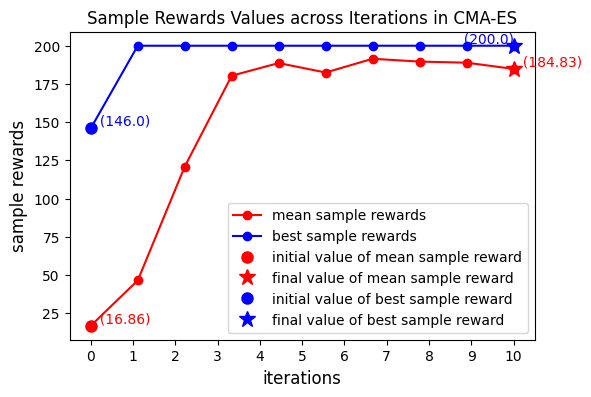

In [8]:
# visualize the best_sample_vec and mean_sample_vec across 10 iterations
plt.figure(figsize=(6, 4))
plt.title("Sample Rewards Values across Iterations in CMA-ES")
x_axis = np.linspace(0,10,10)
y1_axis = mean_sample_vec
y2_axis = best_sample_vec
plt.plot(x_axis, y1_axis, 'r-o',label='mean sample rewards')
plt.plot(x_axis, y2_axis, 'b-o',label='best sample rewards')
plt.plot([x_axis[0]],[mean_sample_vec[0]], 'ro', ms=8, label='initial value of mean sample reward')
plt.plot([x_axis[-1]],[mean_sample_vec[-1]], 'r*', ms=12, label='final value of mean sample reward')
plt.plot([x_axis[0]],[best_sample_vec[0]], 'bo', ms=8, label='initial value of best sample reward')
plt.plot([x_axis[-1]],[best_sample_vec[-1]], 'b*', ms=12, label='final value of best sample reward')
plt.text(x_axis[0], mean_sample_vec[0], '  ({})'.format(mean_sample_vec[0]),fontsize=10,color='r', ha='left',va='bottom')
plt.text(x_axis[-1], mean_sample_vec[-1], '  ({})'.format(mean_sample_vec[-1]),fontsize=10,color='r', ha='left',va='bottom')
plt.text(x_axis[0], best_sample_vec[0], '  ({})'.format(best_sample_vec[0]),fontsize=10,color='b', ha='left',va='bottom')
plt.text(x_axis[-1], best_sample_vec[-1], '  ({})'.format(best_sample_vec[-1]),fontsize=10,color='b', ha='right',va='bottom')
plt.xticks(range(0,11,1))
plt.xlabel('iterations',fontsize=12)
plt.ylabel('sample rewards',fontsize=12)
plt.legend()
plt.show()